INFORMACION GENERAL

In [1]:
#Importación de las librerías 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import numpy as np 
import math as mth

In [2]:
#Lectura del DataFrame 
data=pd.read_csv(r'./datasets/logs_exp_us.csv' , sep='\t', encoding='latin1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
data.head()

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

PREPARACIÓN DE LOS DATOS PARA EL ANÁLISIS

In [4]:
data.rename(columns={'EventName':'event','DeviceIDHash':'userId','EventTimestamp':'event_time','ExpId':'group'},inplace=True)

In [5]:
#Verificaremos si hay filas duplicadas
data.duplicated().value_counts()

False    243713
True        413
Name: count, dtype: int64

In [6]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event       243713 non-null  object
 1   userId      243713 non-null  int64 
 2   event_time  243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [7]:
#En la columna group tenemos los distintos grupos, en los que los grupos 246 y 247 son los grupos de control y 248 es del grupo  de prueba
print(data['group'].value_counts())


group
248    85582
246    80181
247    77950
Name: count, dtype: int64


In [8]:
#Creacion de la columna date con la fecha y cambio del tipo event_time con fecha y hora.
data['event_time']=pd.to_datetime(data['event_time'], unit='s').dt.floor('H')
data['date']=data['event_time'].dt.date
data.head()


/var/folders/ls/mn9lpq6d31zfvyfd015w0r8m0000gn/T/ipykernel_6728/322689481.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['event_time']=pd.to_datetime(data['event_time'], unit='s').dt.floor('H')


event               userId          event_time  group  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:00:00    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:00:00    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:00:00    248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:00:00    248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:00:00    248   

         date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25

In [9]:
#Cuantos eventos hay en los registros?
print(data['event'].value_counts())

event
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64


In [10]:
#Cuantos usuarios hay en los registros?
num_users=data['userId'].nunique()
print(num_users)

7551


In [11]:
#Promedio de eventos por usuario
user_event_mean=data.groupby('userId')['event'].count().mean()
print(user_event_mean)

32.27559263673685


In [12]:
#Fecha maxima y minima 
print('Fecha máxima de evento ', data['date'].max())
print('Fecha mínima de evento ', data['date'].min())

Fecha máxima de evento  2019-08-07
Fecha mínima de evento  2019-07-25


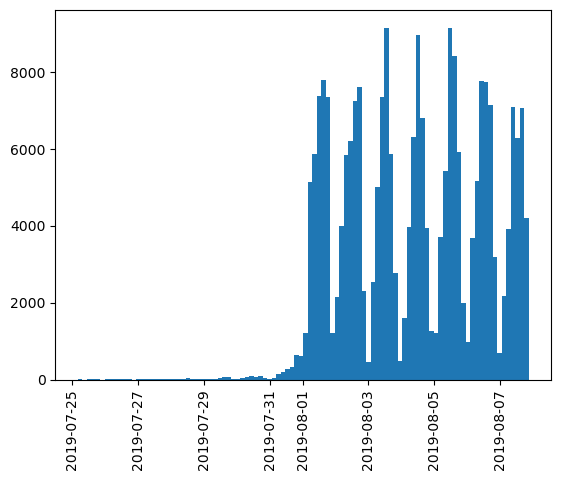

In [13]:
#Histograma por fecha y hora
plt.hist(data['event_time'], bins=100)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='event_time'>

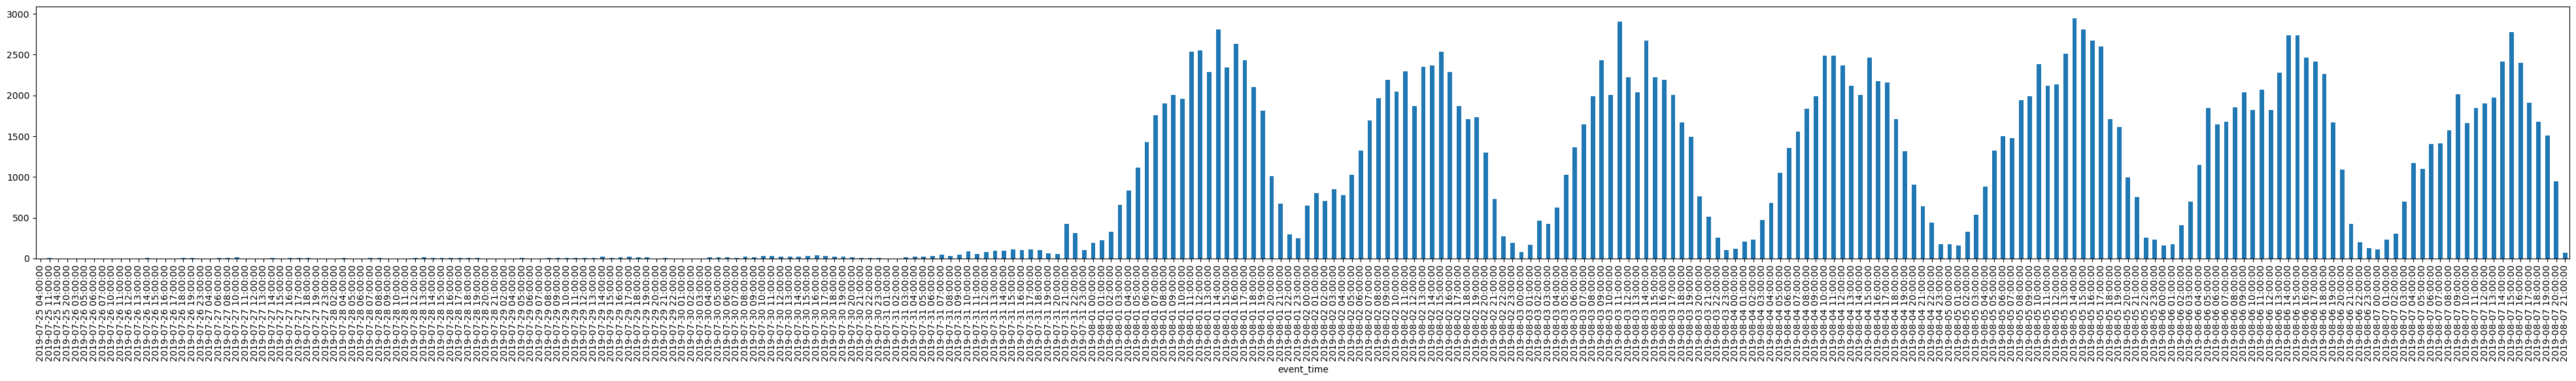

In [14]:
#Grafica de barras por fecha y hora
events_by_day=data.groupby('event_time').size()
events_by_day.plot(kind='bar', figsize=(50, 5), rot=90)

De ambas graficas coincide que la obtencion de datos  que se comporte de forma mas regular fue a partir del 2019-08-01, por lo que los datos pasados podrian no influir, pero debemos corroborar.

<Axes: xlabel='event_time'>

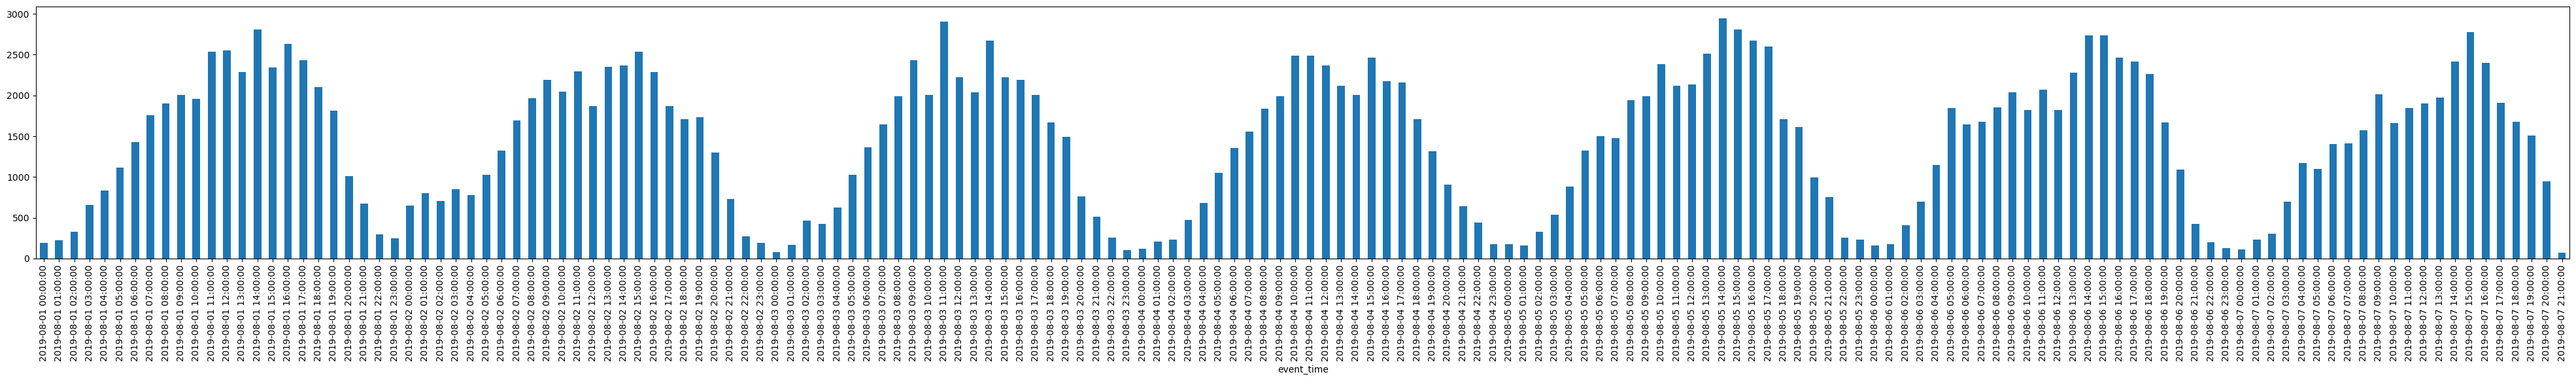

In [15]:
#Primero quitaremos los datos anteriores al 2019-08-01 
data['date']=pd.to_datetime(data['date'])
data_=data[data['date']>='2019-08-01']
events_by_day=data_.groupby('event_time').size()
events_by_day.plot(kind='bar', figsize=(50, 5), rot=90)


In [16]:
#En la columna group tenemos los distintos grupos, en los que los grupos 246 y 247 son los grupos de control y 248 es del grupo  de prueba
print(data_['group'].value_counts())
#Cuantos eventos hay en los registros?
print(data_['event'].value_counts())

group
248    84563
246    79302
247    77022
Name: count, dtype: int64
event
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64


Al excluir los datos mas antiguos no se perdieron muchos sujetos de los grupos para las pruebas, en el caso de los eventos la mayor perdida fue del evento MainScreenAppear, en el caso del evento PaymentScreenSuccesful solo tuvimos alrededor de 200 perdidas de informacion, para los 33918 que se mantuvieron la perdida es minima.

                     stage  quantity
0         MainScreenAppear    117328
1       OffersScreenAppear     46333
2         CartScreenAppear     42303
3  PaymentScreenSuccessful     33918
4                 Tutorial      1005


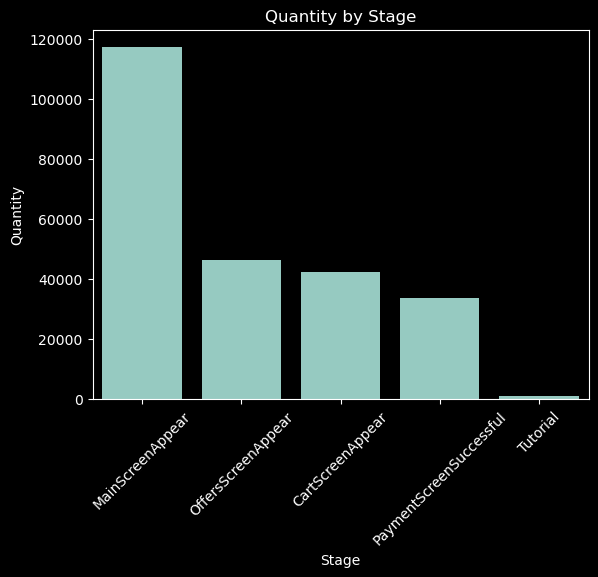

In [17]:
#Creacion de DF data_by_satge
data_by_stage=data_['event'].value_counts().reset_index()
data_by_stage.rename(columns={'event':'stage','count':'quantity'},inplace=True)
print(data_by_stage)

plt.style.use('dark_background')
sns.barplot(x='stage',y='quantity',data=data_by_stage)
plt.xlabel('Stage')
plt.ylabel('Quantity')
plt.title('Quantity by Stage')
plt.xticks(rotation=45)
plt.show()

Lo que se tiene del codigo y embudo anteriores la cantidad de eventos que hubo y las veces que se repitieron, podria ser que de las 1005 veces que se repitio o hubo el evento el Tutorial hayan sido todas por las mismas 2 o 3 personas, por eso debemos ver la cantidad de persoans que pasaron por cada evento, nos dara mas información.

In [18]:
data_by_stage=data_.groupby('event').agg({'userId':'nunique'}).sort_values(by='userId', ascending=False).reset_index()
data_by_stage.rename(columns={'event':'stage','userId':'users'},inplace=True)
print(data_by_stage)

                     stage  users
0         MainScreenAppear   7419
1       OffersScreenAppear   4593
2         CartScreenAppear   3734
3  PaymentScreenSuccessful   3539
4                 Tutorial    840


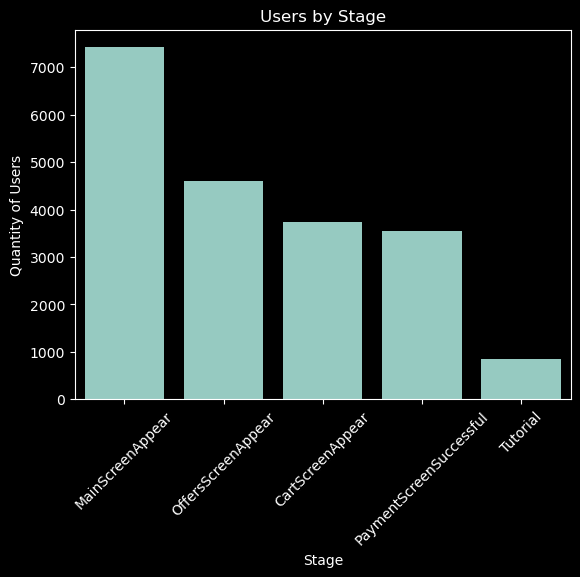

In [19]:
plt.style.use('dark_background')
sns.barplot(x='stage',y='users',data=data_by_stage)
plt.xlabel('Stage')
plt.ylabel('Quantity of Users')
plt.title('Users by Stage')
plt.xticks(rotation=45)
plt.show()

Con esto determinamos la cantidad de usuarios que pasan por cada etapa, para determinar la proporcion tenemos 

Etapa/                            Cantidad/                     Conversion total/                  Conversion a la suiguiente etapa

MainScreenAppear                    7419                            100%                                        100%

OffersScreenAppear                  4593                            61.9%                                       61.9%

CartScreenAppear                    3734                            50.3%                                       81.3%

PaymentScreenSuccessful             3539                            47.7%                                       94.8%

Tutorial                            840                             11.32%                                      23.7%

El orden en el que creo que pasaron los eventos o que ocurrieron las acciones es el que lleva el embudo excepto por el tutorial, primero se realiza el tutorial pero muchos lo omiten, despues aparece la pagina principa, despues la pantalla de una oferta, se agrega al carrito de compra y se realiza el pago.

Se puede ver que cuando se pierden mas usuarios como lo muestra nuestro embudo es de la pagina principal a la de ofertas, quiza algunos usuarios no les gusto el como se distribuia la pagina principal o no vieron algun anuncio de oferta, despues se pierden mas usuarios al momento de realizar el tutorial 

In [20]:
#Formaremos los grupos A246 y A247, ademas del B (que corresponde a los que tienen 248)

group_A246=data_[data_['group']==246]
group_A247=data_[data_['group']==247]
group_B=data_[data_['group']==248]

#Lo que haremos es agrupar por dia en que se entra a la aplicacion y veremos la cantidad de usuarios unicos que entran sin importar el evento
#o si realizaron mas de un evento por dia
group_A246_by_day=group_A246.groupby(['date'])['userId'].nunique().reset_index()
print(group_A246_by_day)

        date  userId
0 2019-08-01    1191
1 2019-08-02    1197
2 2019-08-03    1140
3 2019-08-04    1170
4 2019-08-05    1269
5 2019-08-06    1270
6 2019-08-07    1198


In [21]:
#Lo mismo que en las lineas anteriores lo haremos para el grupo A247
group_A247_by_day=group_A247.groupby(['date'])['userId'].nunique().reset_index()
print(group_A247_by_day)

        date  userId
0 2019-08-01    1282
1 2019-08-02    1221
2 2019-08-03    1176
3 2019-08-04    1169
4 2019-08-05    1263
5 2019-08-06    1320
6 2019-08-07    1212


In [22]:
#Para la prueba tendremos un alpha=0.05
alpha=0.05
results_A246_A247=st.ttest_ind(group_A246_by_day['userId'],group_A247_by_day['userId'])
bonferroni_alpha=alpha/2

print('Valor p para comparar los grupos A246 y A247: ', results_A246_A247.pvalue)
if(results_A246_A247.pvalue < bonferroni_alpha):
    print('Hipotesis nula rechazada para los grupos A246 y A247')
else:
    print('Hipotesis nula no rechazada para los grupos A246 y A247')

Valor p para comparar los grupos A246 y A247:  0.30899748048237163
Hipotesis nula no rechazada para los grupos A246 y A247


En esta prueba los datos no confirman que exista una diferencia en el numero de usuarios de un grupo a otro, pero ahora debemos ver si no existe la diferencia por el numero de eventos, ya que si llega a existir los usuarios de un grupo son mas activos que los del otro grupo.

In [23]:
group_A246=data_[data_['group']==246]
group_A247=data_[data_['group']==247]
group_B=data_[data_['group']==248]
group_A246_by_day=group_A246.groupby(['date'])['userId'].count().reset_index()
#print(group_A246_by_day)
group_A247_by_day=group_A247.groupby(['date'])['userId'].count().reset_index()
#print(group_A247_by_day)
alpha=0.05
results_A246_A247=st.ttest_ind(group_A246_by_day['userId'],group_A247_by_day['userId'])
bonferroni_alpha=alpha/2

print('Valor p para comparar los grupos A246 y A247: ', results_A246_A247.pvalue)
if(results_A246_A247.pvalue < bonferroni_alpha):
    print('Hipotesis nula rechazada para los grupos A246 y A247')
else:
    print('Hipotesis nula no rechazada para los grupos A246 y A247')

Valor p para comparar los grupos A246 y A247:  0.43158974511062054
Hipotesis nula no rechazada para los grupos A246 y A247


Por lo tanto tampoco podemos rechazar la hipotesis de que la cantidad de eventos de un grupo es igual a la del otro grupo.

In [24]:
#Cantidad de usuarios por grupo que realiza cada accion-evento
a1_events=group_A246.groupby('event').agg({'userId':'nunique'}).reset_index().sort_values('userId', ascending=False)
a2_events=group_A247.groupby('event').agg({'userId':'nunique'}).reset_index().sort_values('userId', ascending=False)
a_merged=pd.merge(a1_events,a2_events, on='event')
a_merged.columns=['event','users_A246', 'users_A247']
print(a_merged)

                     event  users_A246  users_A247
0         MainScreenAppear        2450        2476
1       OffersScreenAppear        1542        1520
2         CartScreenAppear        1266        1238
3  PaymentScreenSuccessful        1200        1158
4                 Tutorial         278         283


In [25]:
group_A1_by_day_event=group_A246.groupby(['date','event'])['userId'].nunique().reset_index()
group_A2_by_day_event=group_A247.groupby(['date','event'])['userId'].nunique().reset_index()
group_B_by_day_event=group_B.groupby(['date','event'])['userId'].nunique().reset_index()

#Funcion para determinar la diferencia estadistica entre los dos grupos, el parametro de la funcion es solo el evento, funciona solo para 
# los grupos 246 y 247
 
def test_groups(event):
    event_group_1=group_A1_by_day_event[group_A1_by_day_event['event']==event]['userId']
    event_group_2=group_A2_by_day_event[group_A2_by_day_event['event']==event]['userId']
    alpha=0.05

#Determinaremos si las distribuciones de cada evento son normales o no, para hacerlo usaremos la prueba de Shapiro. Al ser normales
#podremos usar la prueba .ttest_ind()
    results1_shap=st.shapiro(event_group_1)
    p_value1=results1_shap[1]
    if (p_value1<alpha):
        print('Hipotesis nula rechazada: la distribucion A1 no es normal')
    else:
        print('Hipotesis nula no rechazada: la distribucion A1 parece ser normal')

    results2_shap=st.shapiro(event_group_2)
    p_value2=results2_shap[1]
    if (p_value2<alpha):
        print('Hipotesis nula rechazada: la distribucion A2 no es normal')
    else:
        print('Hipotesis nula no rechazada: la distribucion A2 parece ser normal')



    result_test=st.ttest_ind(event_group_1,event_group_2)
    bonferroni_alpha=alpha/2
    print('Valor p para comparar los grupos A1 y A2 en el evento {0}: {1}'.format(event,result_test.pvalue))
    if(result_test.pvalue < bonferroni_alpha):
        print('Hipotesis nula rechazada para los grupos A1 y A2')
    else:
        print('Hipotesis nula no rechazada para los grupos A1 y A2')


In [26]:
#CartScreenAppear
#MainScreenAppear
#OffersScreenAppear
#PaymentScreenSuccessful
#Tutorial
test_groups('MainScreenAppear')
print()
test_groups('OffersScreenAppear')
print()
test_groups('CartScreenAppear')
print()
test_groups('PaymentScreenSuccessful')
print()
test_groups('Tutorial')


Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Valor p para comparar los grupos A1 y A2 en el evento MainScreenAppear: 0.3935679120702118
Hipotesis nula no rechazada para los grupos A1 y A2

Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Valor p para comparar los grupos A1 y A2 en el evento OffersScreenAppear: 0.8992195747296515
Hipotesis nula no rechazada para los grupos A1 y A2

Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Valor p para comparar los grupos A1 y A2 en el evento CartScreenAppear: 0.45738561642044917
Hipotesis nula no rechazada para los grupos A1 y A2

Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Valor p para comparar los grupos A1 y

Podemos determinar que en la distribucion de las medias los grupos A1 y A2 que corresponden a 246 y 247, no son distintas, ahora debemos determinar se las proporciones lo son...

In [27]:
purchases=np.array([a_merged['users_A246'][3],a_merged['users_A247'][3]])
leads=np.array([a_merged['users_A246'][0],a_merged['users_A247'][0]])
#print(purchases)
#print(leads)
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=(purchases[0]+purchases[1])/(leads[0]+leads[1])
difference=p1-p2

z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))

distr=st.norm(0,1)
p_value=(1-distr.cdf(abs(z_value)))*2

print('p-value: ',p_value)
if(p_value<alpha):
    print('Rechazar la hipotesis nula: hay una diferencia significativa entre las proporciones')
else:
    print('No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes')

p-value:  0.12044299485641763
No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes


Con esto podemos determinar que los grupos de prueba A estan bien  distribuidos, es decir que se dividieron correctamente. 

PARA LAS PRUEBAS ENTRE A246 Y B

In [28]:
#Ahora para el caso de la prueba de los grupos A y B tenemos 
b_events=group_B.groupby('event').agg({'userId':'nunique'}).reset_index().sort_values('userId', ascending=False)
a_and_b_merged=pd.merge(a_merged,b_events, on='event')
a_and_b_merged.rename(columns={'userId':'users_B248'},inplace=True)
print(a_and_b_merged)

                     event  users_A246  users_A247  users_B248
0         MainScreenAppear        2450        2476        2493
1       OffersScreenAppear        1542        1520        1531
2         CartScreenAppear        1266        1238        1230
3  PaymentScreenSuccessful        1200        1158        1181
4                 Tutorial         278         283         279


In [29]:
def test_groups_a1b(event):
    event_group_1=group_A1_by_day_event[group_A1_by_day_event['event']==event]['userId']
    event_group_2=group_B_by_day_event[group_B_by_day_event['event']==event]['userId']
    alpha=0.05

#Determinaremos si las distribuciones de cada evento son normales o no, para hacerlo usaremos la prueba de Shapiro. Al ser normales
#podremos usar la prueba .ttest_ind()
    results1_shap=st.shapiro(event_group_1)
    p_value1=results1_shap[1]
    if (p_value1<alpha):
        print('Hipotesis nula rechazada: la distribucion A1 no es normal')
    else:
        print('Hipotesis nula no rechazada: la distribucion A1 parece ser normal')

    results2_shap=st.shapiro(event_group_2)
    p_value2=results2_shap[1]
    if (p_value2<alpha):
        print('Hipotesis nula rechazada: la distribucion B no es normal')
    else:
        print('Hipotesis nula no rechazada: la distribucion B parece ser normal')



    result_test=st.ttest_ind(event_group_1,event_group_2)
    bonferroni_alpha=alpha/2
    print('Valor p para comparar los grupos A1 y B en el evento {0}: {1}'.format(event,result_test.pvalue))
    if(result_test.pvalue < bonferroni_alpha):
        print('Hipotesis nula rechazada para los grupos A1 y B')
    else:
        print('Hipotesis nula no rechazada para los grupos A1 y B')


In [30]:
test_groups_a1b('MainScreenAppear')
print()
test_groups_a1b('OffersScreenAppear')
print()
test_groups_a1b('CartScreenAppear')
print()
test_groups_a1b('PaymentScreenSuccessful')
print()
test_groups_a1b('Tutorial')


Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A1 y B en el evento MainScreenAppear: 0.2527868023318047
Hipotesis nula no rechazada para los grupos A1 y B

Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A1 y B en el evento OffersScreenAppear: 0.9521413199050492
Hipotesis nula no rechazada para los grupos A1 y B

Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A1 y B en el evento CartScreenAppear: 0.8981940143595246
Hipotesis nula no rechazada para los grupos A1 y B

Hipotesis nula no rechazada: la distribucion A1 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A1 y B en el ev

In [31]:
purchases=np.array([a_and_b_merged['users_A246'][3],a_and_b_merged['users_B248'][3]])
leads=np.array([a_and_b_merged['users_A246'][0],a_and_b_merged['users_B248'][0]])
#print(purchases)
#print(leads)
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=(purchases[0]+purchases[1])/(leads[0]+leads[1])
difference=p1-p2

z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))

distr=st.norm(0,1)
p_value=(1-distr.cdf(abs(z_value)))*2

print('p-value: ',p_value)
if(p_value<alpha):
    print('Rechazar la hipotesis nula: hay una diferencia significativa entre las proporciones')
else:
    print('No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes')

p-value:  0.2582638437556217
No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes


PARA LAS PRUEBAS DE A247 Y B

In [32]:
def test_groups_a2b(event):
   
    event_group_1=group_A2_by_day_event[group_A2_by_day_event['event']==event]['userId']
    event_group_2=group_B_by_day_event[group_B_by_day_event['event']==event]['userId']
    alpha=0.05

#Determinaremos si las distribuciones de cada evento son normales o no, para hacerlo usaremos la prueba de Shapiro. Al ser normales
#podremos usar la prueba .ttest_ind()
    results1_shap=st.shapiro(event_group_1)
    p_value1=results1_shap[1]
    if (p_value1<alpha):
        print('Hipotesis nula rechazada: la distribucion A2 no es normal')
    else:
        print('Hipotesis nula no rechazada: la distribucion A2 parece ser normal')

    results2_shap=st.shapiro(event_group_2)
    p_value2=results2_shap[1]
    if (p_value2<alpha):
        print('Hipotesis nula rechazada: la distribucion B no es normal')
    else:
        print('Hipotesis nula no rechazada: la distribucion B parece ser normal')



    result_test=st.ttest_ind(event_group_1,event_group_2)
    bonferroni_alpha=alpha/2
    print('Valor p para comparar los grupos A2 y B en el evento {0}: {1}'.format(event,result_test.pvalue))
    if(result_test.pvalue < bonferroni_alpha):
        print('Hipotesis nula rechazada para los grupos A2 y B')
    else:
        print('Hipotesis nula no rechazada para los grupos A2 y B')


In [33]:
test_groups_a2b('MainScreenAppear')
print()
test_groups_a2b('OffersScreenAppear')
print()
test_groups_a2b('CartScreenAppear')
print()
test_groups_a2b('PaymentScreenSuccessful')
print()
test_groups_a2b('Tutorial')


Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A2 y B en el evento MainScreenAppear: 0.7816239522799555
Hipotesis nula no rechazada para los grupos A2 y B

Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A2 y B en el evento OffersScreenAppear: 0.9373705306000786
Hipotesis nula no rechazada para los grupos A2 y B

Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A2 y B en el evento CartScreenAppear: 0.5864714314554476
Hipotesis nula no rechazada para los grupos A2 y B

Hipotesis nula no rechazada: la distribucion A2 parece ser normal
Hipotesis nula no rechazada: la distribucion B parece ser normal
Valor p para comparar los grupos A2 y B en el ev

In [34]:
purchases=np.array([a_and_b_merged['users_A247'][3],a_and_b_merged['users_B248'][3]])
leads=np.array([a_and_b_merged['users_A247'][0],a_and_b_merged['users_B248'][0]])
#print(purchases)
#print(leads)
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=(purchases[0]+purchases[1])/(leads[0]+leads[1])
difference=p1-p2

z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))

distr=st.norm(0,1)
p_value=(1-distr.cdf(abs(z_value)))*2

print('p-value: ',p_value)
if(p_value<alpha):
    print('Rechazar la hipotesis nula: hay una diferencia significativa entre las proporciones')
else:
    print('No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes')

p-value:  0.6699208079332859
No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes


CON ESTAS PRUEBAS PODEMOS DETERMINAR QUE LOS GRUPOS FUERON DIVIDIDOS CORRECTAMENTE  PERO ENTRE LOS GRUPOS A Y B NOS DICE QUE LOS CAMBIOS NO FUERON SIGNIFICATIVOS O QUE NO HAY EVIDENCIA CLARA DE QUE LO SEAN.

PRUEBA PARA A246 Y A247

In [35]:
#CON UN NIVEL DE SIGNIFICANCIA MAYOR, COMO EL 10% PODEMOS OBTENER 
alpha=.1
purchases=np.array([a_merged['users_A246'][3],a_merged['users_A247'][3]])
leads=np.array([a_merged['users_A246'][0],a_merged['users_A247'][0]])
#print(purchases)
#print(leads)
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=(purchases[0]+purchases[1])/(leads[0]+leads[1])
difference=p1-p2

z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))

distr=st.norm(0,1)
p_value=(1-distr.cdf(abs(z_value)))*2

print('p-value: ',p_value)
if(p_value<alpha):
    print('Rechazar la hipotesis nula: hay una diferencia significativa entre las proporciones')
else:
    print('No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes')


p-value:  0.12044299485641763
No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes


PRUEBA PARA A246 Y B

In [36]:
purchases=np.array([a_and_b_merged['users_A246'][3],a_and_b_merged['users_B248'][3]])
leads=np.array([a_and_b_merged['users_A246'][0],a_and_b_merged['users_B248'][0]])
#print(purchases)
#print(leads)
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=(purchases[0]+purchases[1])/(leads[0]+leads[1])
difference=p1-p2

z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))

distr=st.norm(0,1)
p_value=(1-distr.cdf(abs(z_value)))*2

print('p-value: ',p_value)
if(p_value<alpha):
    print('Rechazar la hipotesis nula: hay una diferencia significativa entre las proporciones')
else:
    print('No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes')

p-value:  0.2582638437556217
No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes


PRUEBA PARA A247 Y B

In [37]:
purchases=np.array([a_and_b_merged['users_A247'][3],a_and_b_merged['users_B248'][3]])
leads=np.array([a_and_b_merged['users_A247'][0],a_and_b_merged['users_B248'][0]])
#print(purchases)
#print(leads)
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=(purchases[0]+purchases[1])/(leads[0]+leads[1])
difference=p1-p2

z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))

distr=st.norm(0,1)
p_value=(1-distr.cdf(abs(z_value)))*2

print('p-value: ',p_value)
if(p_value<alpha):
    print('Rechazar la hipotesis nula: hay una diferencia significativa entre las proporciones')
else:
    print('No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes')

p-value:  0.6699208079332859
No se pudo rechazar la hipotesis nula: no hay razon para pensar que las proporciones son diferentes


Se realizan las pruebas con 0.1 del nivel de significancia, sin embargo para que almenos una de las hipotesis sea rechazada se requiere un nivel de significancia del 13%, es decir 0.13